[('HG00514', 'CLR'), ('HG00514', 'HiFi'), ('NA12329', 'CLR')]
---------------


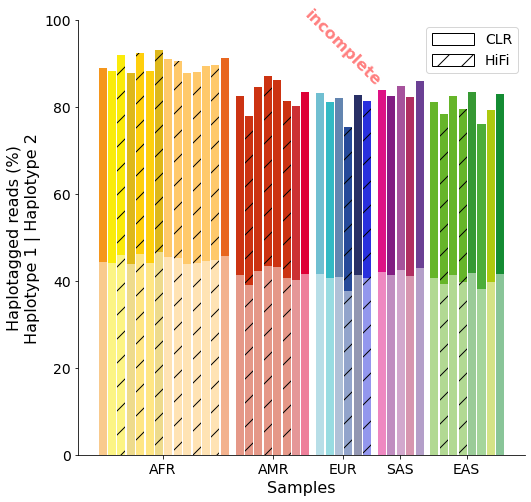

In [10]:
import os
import csv
import collections
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/fig1_panels/haplotag_stats'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_haplotagging-stats')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def load_haplotagging_stats(file_path):
    stats = dict()
    with open(file_path, 'r', newline='') as table:
        for row in table:
            if not row.startswith('percent'):
                continue
            k, v = row.split()
            tag_type = k.split('_')[-1]
            stats[tag_type] = float(v) 
    return stats


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.tsv',
        pipeline_version)
    plot_data = [load_haplotagging_stats(fp) for fp in stat_files]

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in stat_files]
    row_index = []
    for sample, platform in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform))

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_index
    )

    df.index = pd.MultiIndex.from_tuples(df.index.values, names=['sample', 'super_pop', 'pop', 'platform'])
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform'])

errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')

def plot_tagging_statistic(sample_stats):
    
    bar_width = prop('bar_width')

    fig, axis = plt.subplots(figsize=(8,8))
    
    value_collector = collections.defaultdict(list)
    x_pos_counter = 0
    
    x_pos_spop = collections.defaultdict(list)
    
    for sp in plot_aux.get_population_sorting():
        try:
            subset = sample_stats.xs(sp, level=1, drop_level=False)
        except KeyError:
            continue
        for index, row in subset.iterrows():
            color = rgbcodes[index[2]]
            hap1 = row['hap1']
            hap2 = row['hap2']
            x_pos_counter += prop('bar_intra_spacing')

            value_collector[(index[3], 'hap1')].append(hap1)
            value_collector[(index[3], 'hap2')].append(hap2)
            value_collector[(index[3], 'colors')].append(color)
            value_collector[(index[3], 'x_pos')].append(x_pos_counter)
            x_pos_spop[sp].append(x_pos_counter)
        x_pos_counter += prop('bar_inter_spacing')
    
    for platform in ['HiFi', 'CLR']:
        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'hap1')],
            bar_width,
            label='Hap1',
            color=value_collector[(platform, 'colors')],
            alpha=0.5,
            hatch='/' if platform == 'HiFi' else None
        )

        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'hap1')],
            bar_width,
            bottom=value_collector[(platform, 'hap1')],
            label='Hap2',
            color=value_collector[(platform, 'colors')],
            hatch='/' if platform == 'HiFi' else None
        )
    
    axis.set_xlabel(
        'Samples',
        fontsize=prop('fontsize_axis_label')
    )
    axis.set_ylabel(
        'Haplotagged reads (%)\nHaplotype 1 | Haplotype 2',
        fontsize=prop('fontsize_axis_label')
    )
    axis.set_ylim(0, 100)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

    xticks = []
    for sp in plot_aux.get_population_sorting():
        xvals = x_pos_spop[sp]
        mid_pos = round((min(xvals) + max(xvals)) / 2, 1)
        xticks.append(mid_pos)
    
    axis.set_xticks(xticks)
    axis.set_xticklabels(plot_aux.get_population_sorting())
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    # build custom legend
    custom_patches = [
#         patches.Patch(facecolor=rgbcodes['AFR'], edgecolor=None,
#                       label='AFR'),
#         patches.Patch(facecolor=rgbcodes['AMR'], edgecolor=None,
#                       label='AMR'),
#         patches.Patch(facecolor=rgbcodes['EAS'], edgecolor=None,
#                       label='EAS'),
#         patches.Patch(facecolor=rgbcodes['EUR'], edgecolor=None,
#                       label='EUR'),
#         patches.Patch(facecolor=rgbcodes['SAS'], edgecolor=None,
#                       label='SAS'),
#         patches.Patch(facecolor='white', edgecolor=None,
#                       label=''),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='CLR'),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='HiFi', hatch='/'),
    ]
    
    axis.legend(
        handles=custom_patches,
        loc='upper right',
        handlelength=3,
        handleheight=1,
        prop={'size': prop('fontsize_legend')}
    )
    
    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.5, 0.85)
    
    extra_artists = []
    
    return fig, extra_artists

fig, exart = plot_tagging_statistic(df)

fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
